In [24]:
import os
import json
import pandas as pd
import xgboost as xgb
import configparser
from snowflake.snowpark import Session
from copy import copy
from snowflake.snowpark import Row
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path, udf, udtf, table_function, sproc, seq8, uniform
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException
from snowflake.snowpark.files import SnowflakeFile
from snowflake.snowpark.column import METADATA_FILENAME, METADATA_FILE_ROW_NUMBER

# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('assets/credentials.cfg')

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  config['SNOWPARKAWS']['SNOWFLAKE_ROLE'],  # optional
   warehouse =  config['SNOWPARKAWS']['SNOWFLAKE_WAREHOUSE'],  # optional
   database  =  config['SNOWPARKAWS']['SNOWFLAKE_DATABASE'],  # optional
   schema    =  config['SNOWPARKAWS']['SNOWFLAKE_SCHEMA'],  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

#### ``Access and load data in various supported formats using Snowpark DataFrameReader Class``

- The DataFrameReader provides methods to load data in various supported formats from a Snowflake stage to a DataFrame. The paths provided to the DataFrameReader must refer to Snowflake stages.

`To use the DataFrameReader:`
- Access an instance of a DataFrameReader by using the Session.read property
- Specify any format-specific options and copy options by calling the option() or options() method
- Specify the schema of the data that you plan to load and pass it to the schema() method if the file format is CSV. Other file formats such as JSON, XML, Parquet, ORC, and AVRO don’t accept a schema.
- Specify the format of the data by calling the method named after the format (e.g. csv(), json(), etc.). These methods return a DataFrame that is configured to load data in the specified format.
- Call a DataFrame method that performs an action (e.g. DataFrame.collect()) to load the data from the file.

In [3]:
session.sql("show stages in schema snowpark_db.public").show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"          |"database_name"  |"schema_name"  |"url"  |"has_credentials"  |"has_encryption_key"  |"owner"   |"comment"  |"region"  |"type"    |"cloud"  |"notification_channel"  |"storage_integration"  |"endpoint"  |"owner_role_type"  |"directory_enabled"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2023-12-08 07:28:19.927000-08:00  |SF_INT_STG      |SNOWPARK_DB      |PUBLIC         |       |N          

- [Session.file](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Session.file)
- [FileOperation](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.FileOperation#snowflake.snowpark.FileOperation)
- [FileOperation.put](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.FileOperation.put#snowflake.snowpark.FileOperation.put)

In [9]:
# Upload local files into Snowflake internal stage
session.file.put("datasets/csv_dataset.csv", "@SF_INT_STG", auto_compress=False, overwrite=True)
session.file.put("datasets/avro_dataset.avro", "@SF_INT_STG", auto_compress=False, overwrite=True)
session.file.put("datasets/json_dataset.json", "@SF_INT_STG", auto_compress=False, overwrite=True)
session.file.put("datasets/orc_dataset.orc", "@SF_INT_STG", auto_compress=False, overwrite=True)
session.file.put("datasets/xml_dataset.xml", "@SF_INT_STG", auto_compress=False, overwrite=True)
session.file.put("datasets/cities.parquet", "@SF_INT_STG", auto_compress=False, overwrite=True)


[PutResult(source='cities.parquet', target='cities.parquet', source_size=866, target_size=880, source_compression='PARQUET', target_compression='PARQUET', status='UPLOADED', message='')]

In [11]:
# Dataset validation
session.sql("list @SF_INT_STG").show(25)

--------------------------------------------------------------------------------------------------------------
|"name"                        |"size"    |"md5"                             |"last_modified"                |
--------------------------------------------------------------------------------------------------------------
|sf_int_stg/avro_dataset.avro  |19114464  |71cf879b3e591be4443b9bbee339d394  |Thu, 14 Dec 2023 15:07:51 GMT  |
|sf_int_stg/car_sales.json     |848       |d69652cd0d10f4651db31c180bd8dff6  |Fri, 8 Dec 2023 17:25:35 GMT   |
|sf_int_stg/car_sales1.json    |656       |04c4262b096991965a9887a75393ef8d  |Sat, 9 Dec 2023 00:59:33 GMT   |
|sf_int_stg/cities.parquet     |880       |66d6d49b068c5062c4ac8e7c7aaeef8b  |Thu, 14 Dec 2023 15:07:56 GMT  |
|sf_int_stg/csv_dataset.csv    |160       |d77e3d06f74284db17409715dbbece10  |Thu, 14 Dec 2023 15:07:46 GMT  |
|sf_int_stg/data1.csv          |32        |ba2e510d1d6a424a5b0da2be426dad7f  |Fri, 8 Dec 2023 15:30:23 GMT   |
|

`snowflake.snowpark.DataFrameReader`
 - [DataFrameReader](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameReader#snowflake.snowpark.DataFrameReader)

In [14]:
# Loading CSV file
csv_schema = StructType([StructField("Email No.",StringType()), StructField("the",IntegerType()), StructField("to",IntegerType())])

csv_df=session.read.options({"field_delimiter":",", "skip_header":1, "pattern":".*[.]csv"}).schema(csv_schema).csv("@sf_int_stg/csv_dataset.csv")
csv_df.show()

------------------------------
|"Email No."  |"THE"  |"TO"  |
------------------------------
|Email 1      |0      |11    |
|Email 2      |8      |3     |
|Email 3      |0      |3     |
|Email 4      |0      |5     |
|Email 5      |7      |12    |
|Email 6      |4      |44    |
|Email 7      |5      |9     |
|Email 8      |0      |33    |
|Email 9      |2      |5     |
|Email 10     |4      |1     |
------------------------------



In [16]:
# Loading JSON file
json_df = session.read.option("compression","NONE").json("@sf_int_stg/json_dataset.json")
json_df.count()

1

In [19]:
# Loading a Parquet file with inferring the schema.

#parquet_df = session.read.option("compression","NONE").parquet("@sf_int_stg/cities.parquet")
parquet_df = session.read.option("compression","NONE").parquet("@sf_int_stg/cities.parquet").filter(col('"continent"') == 'North America')
parquet_df.show()

--------------------------------------
|"continent"    |"country"           |
--------------------------------------
|North America  |{                   |
|               |  "city": [         |
|               |    "Toronto",      |
|               |    "Vancouver",    |
|               |    "St. John's",   |
|               |    "Saint John",   |
|               |    "Montreal",     |
|               |    "Halifax",      |
|               |    "Winnipeg",     |
|               |    "Calgary",      |
|               |    "Saskatoon",    |
|               |    "Ottawa",       |
|               |    "Yellowknife"   |
|               |  ],                |
|               |  "name": "Canada"  |
|               |}                   |
--------------------------------------



In [4]:
# To load Parquet, ORC and AVRO files, no schema is accepted because the schema will be automatically inferred. Inferring the schema can be disabled by setting option “infer_schema” to False. Then you can use $1 to access the column data as an OBJECT.
parquet_df = session.read.options({"compression":"NONE", "infer_schema":False}).parquet("@sf_int_stg/cities.parquet")
parquet_df.show()

-----------------------------------
|"$1"                             |
-----------------------------------
|{                                |
|  "continent": "Europe",         |
|  "country": {                   |
|    "city": [                    |
|      "Paris",                   |
|      "Nice",                    |
|      "Marseilles",              |
|      "Cannes"                   |
|    ],                           |
|    "name": "France"             |
|  }                              |
|}                                |
|{                                |
|  "continent": "Europe",         |
|  "country": {                   |
|    "city": [                    |
|      "Athens",                  |
|      "Piraeus",                 |
|      "Hania",                   |
|      "Heraklion",               |
|      "Rethymnon",               |
|      "Fira"                     |
|    ],                           |
|    "name": "Greece"             |
|  }                        

In [6]:
# Loading an ORC file and infer the schema:
orc_df = session.read.orc("@sf_int_stg/orc_dataset.orc")
orc_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------
|"boolean1"  |"byte1"  |"short1"  |"int1"  |"long1"      |"float1"            |"double1"  |"bytes1"  |"string1"  |"middle"  |"list"  |"map"  |
----------------------------------------------------------------------------------------------------------------------------------------------
|True        |127      |1024      |42      |45097156608  |3.1414999961853027  |-2.713     |NULL      |NULL       |null      |NULL    |null   |
----------------------------------------------------------------------------------------------------------------------------------------------



In [10]:
# Loading an AVRO file and infer the schema:
session.read.avro('@sf_int_stg/avro_dataset.avro').count()

10000

In [13]:
# Loading an XML file:
session.read.xml("@sf_int_stg/xml_dataset.xml").count()

1

In [16]:
# Querying metadata for staged files:
from snowflake.snowpark.column import METADATA_FILENAME, METADATA_FILE_ROW_NUMBER

csv_schema = StructType([StructField("Email No.",StringType()), StructField("the",IntegerType()), StructField("to",IntegerType())])

meta_df = session.read.with_metadata(METADATA_FILENAME.as_("File_Name"), METADATA_FILE_ROW_NUMBER.as_("Row_Number")).options({"field_delimiter":",", "skip_header":1, "pattern":".*[.]csv"}).schema(csv_schema).csv("@sf_int_stg/csv_dataset.csv")
meta_df.show()

---------------------------------------------------------------
|"FILE_NAME"      |"ROW_NUMBER"  |"Email No."  |"THE"  |"TO"  |
---------------------------------------------------------------
|csv_dataset.csv  |1             |Email 1      |0      |11    |
|csv_dataset.csv  |2             |Email 2      |8      |3     |
|csv_dataset.csv  |3             |Email 3      |0      |3     |
|csv_dataset.csv  |4             |Email 4      |0      |5     |
|csv_dataset.csv  |5             |Email 5      |7      |12    |
|csv_dataset.csv  |6             |Email 6      |4      |44    |
|csv_dataset.csv  |7             |Email 7      |5      |9     |
|csv_dataset.csv  |8             |Email 8      |0      |33    |
|csv_dataset.csv  |9             |Email 9      |2      |5     |
|csv_dataset.csv  |10            |Email 10     |4      |1     |
---------------------------------------------------------------



`Inferring schema for csv and json files (Preview Feature - Open):`

- [DataFrameReader](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameReader#snowflake.snowpark.DataFrameReader)

In [17]:
# CSV File
infr_df = session.read.options({"INFER_SCHEMA":True, "PARSE_HEADER":True}).csv("@sf_int_stg/data1.csv")
infr_df.show()

------------------
|"Name"  |"Age"  |
------------------
|AT&T    |100    |
|IBM     |100    |
------------------



In [3]:
# JSON
df = session.read.option("INFER_SCHEMA", True).json("@sf_int_stg/sales.json")
df.show()

------------------------------------------------------------
|"location"                        |"price"  |"sale_date"  |
------------------------------------------------------------
|{                                 |275836   |2017-03-05   |
|  "state_city": "MA-Lexington",   |         |             |
|  "zip": "40503"                  |         |             |
|}                                 |         |             |
|{                                 |392567   |2017-03-17   |
|  "state_city": "MA-Belmont",     |         |             |
|  "zip": "02478"                  |         |             |
|}                                 |         |             |
|{                                 |389921   |2017-03-21   |
|  "state_city": "MA-Winchester",  |         |             |
|  "zip": "01890"                  |         |             |
|}                                 |         |             |
------------------------------------------------------------



In [4]:
# JSON
df = session.read.options({"INFER_SCHEMA":True}).json("@sf_int_stg/sales.json")
df.show()

------------------------------------------------------------
|"location"                        |"price"  |"sale_date"  |
------------------------------------------------------------
|{                                 |275836   |2017-03-05   |
|  "state_city": "MA-Lexington",   |         |             |
|  "zip": "40503"                  |         |             |
|}                                 |         |             |
|{                                 |392567   |2017-03-17   |
|  "state_city": "MA-Belmont",     |         |             |
|  "zip": "02478"                  |         |             |
|}                                 |         |             |
|{                                 |389921   |2017-03-21   |
|  "state_city": "MA-Winchester",  |         |             |
|  "zip": "01890"                  |         |             |
|}                                 |         |             |
------------------------------------------------------------



#### `Writing Data From Dataframe to Output Destination using Snowflake DataFrameWriter Class`

`snowflake.snowpark.DataFrameWriter provides methods for writing data from a DataFrame to supported output destinations.`

To use DataFrameWriter:
- Create an instance of a DataFrameWriter by accessing the DataFrame.write property.
- Specify the save mode by calling mode(), which returns the same DataFrameWriter that is configured to save data using the specified mode. The default mode is “errorifexists”
- Call save_as_table() or copy_into_location() to save the data to the specified destination

### **snowflake.snowpark.DataFrameWriter.copy_into_location**

Allows you to load the data from a dataframe to a stage.

Important Parameters

- `location` – The destination stage location.
- `partition_by` – Specifies an expression used to partition the unloaded table rows into separate files. It can be a Column, a column name, or a SQL expression.
- `file_format_name` – Specifies an existing named file format to use for unloading data from the table. The named file format determines the format type (CSV, JSON, PARQUET), as well as any other format options, for the data files.
- `file_format_type` – Specifies the type of files unloaded from the table. If a format type is specified, additional format-specific options can be specified in format_type_options.
- `format_type_options` – Depending on the file_format_type specified, you can include more format specific options. Use the options documented in the Format Type Options.
- `header` – Specifies whether to include the table column headings in the output files.
- `copy_options` – The kwargs that are used to specify the copy options. Use the options documented in the [Copy Options](https://docs.snowflake.com/en/sql-reference/sql/copy-into-location#copy-options-copyoptions).


### **snowflake.snowpark.DataFrameWriter.mode**

- `**append**`: Append data of this DataFrame to existing data.
- `**overwrite**`: Overwrite existing data.
- `**errorifexists**`: Throw an exception if data already exists.
- `**ignore**`: Ignore this operation if data already exists.

Default value is `**errorifexists**`.

### **snowflake.snowpark.DataFrameWriter.saveAsTable**

Allows you to store the data into a table from a dataframe.

Important Parameters

- `**table_name**` – A string or list of strings representing table name. If input is a string, it represents the table name; if input is of type iterable of strings, it represents the fully-qualified object identifier (database name, schema name, and table name).
- `**mode**` – One of the following values. When it’s None or not provided, the save mode set by mode() is used.
    - ”append”: Append data of this DataFrame to existing data.
    - ”overwrite”: Overwrite existing data.
    - ”errorifexists”: Throw an exception if data already exists.
    - ”ignore”: Ignore this operation if data already exists.
- `**column_order**` – When mode is “append”, data will be inserted into the target table by matching column sequence or column name. Default is “index”. When mode is not “append”, the column_order makes no difference.
    - ”index”: Data will be inserted into the target table by column sequence. “name”: Data will be inserted into the target table by matching column names. If the target table has more columns than the source DataFrame, use this one.
- `**table_type**` – The table type of table to be created. The supported values are: temp, temporary, and transient. An empty string means to create a permanent table. Learn more about table types here.
- `**block**` – A bool value indicating whether this function will wait until the result is available. When it is False, this function executes the underlying queries of the dataframe asynchronously and returns an AsyncJob.

In [27]:
qh_df = session.sql('SELECT query_id,warehouse_name,user_name,query_tag,query_text FROM SNOWFLAKE.ACCOUNT_USAGE.QUERY_HISTORY LIMIT 1000')

- [DataFrameWriter](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameWriter)
- [copy_into_location](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameWriter.copy_into_location#snowflake.snowpark.DataFrameWriter.copy_into_location)

In [14]:
# LOADING DATA FROM A DATAFRAME TO SNOWFLAKE STAGE
qh_df.write.mode("overwrite").copy_into_location(location='@sf_int_stg/copyloc', partition_by="user_name", file_format_type="parquet", header=True)

[Row(rows_unloaded=1000, input_bytes=36316, output_bytes=36316)]

In [15]:
session.sql("list @sf_int_stg/copyloc").show(50)

----------------------------------------------------------------------------------------------------------------------------------
|"name"                                              |"size"  |"md5"                             |"last_modified"                |
----------------------------------------------------------------------------------------------------------------------------------
|sf_int_stg/copyloc/PLOGANATHAN/data_01b0fc8e-06...  |18000   |4afc3c43bcb4355b0650f41e459b1270  |Thu, 14 Dec 2023 16:46:18 GMT  |
|sf_int_stg/copyloc/WORKSHEETS_APP_USER/data_01b...  |18320   |1aefc8de664d878cf973584a9e813a51  |Thu, 14 Dec 2023 16:46:18 GMT  |
----------------------------------------------------------------------------------------------------------------------------------



- [save_as_table](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameWriter.save_as_table)

In [28]:
# LOADING DATA FROM A DATAFRAME TO SNOWFLAKE TABLE
qh_df.write.save_as_table(table_name="q_history", mode="overwrite", table_type="temporary")

In [30]:
session.table("q_history").limit(10).show()

-----------------------------------------------------------------------------------------------------------------------------------------------------
|"QUERY_ID"                            |"WAREHOUSE_NAME"   |"USER_NAME"          |"QUERY_TAG"  |"QUERY_TEXT"                                        |
-----------------------------------------------------------------------------------------------------------------------------------------------------
|01b09d14-0504-d7c0-0002-02db00016212  |COMPUTE_WH         |PLOGANATHAN          |             |select lf.*                                         |
|                                      |                   |                     |             |from demo_db.public.contacts_json as t1             |
|                                      |                   |                     |             |,lateral flatten(input => t1.customer) as lf        |
|                                      |                   |                     |             |;   

#### `Exploring File Operations using Snowflake Snowpark API`

snowflake.snowpark.FileOperation provides methods for working on files in a stage. To access an object of this class, use [Session.file](https://docs.snowflake.com/ko/developer-guide/snowpark/reference/python/api/snowflake.snowpark.Session.file.html#snowflake.snowpark.Session.file)
Method | Description
| -- | --|
get | Downloads the specified files from a path in a stage to a local directory.
get_stream | Downloads the specified files from a path in a stage and expose it through a stream.
put | Uploads local files to the stage.
put_stream | Uploads local files to the stage via a file stream.

**_The put_stream uses the file/data already in memory using a BytesIO object and then writes the object to the internal stage. Where the PUT saves the physical file on the disk and then writes the file to the internal stage_**

### **snowflake.snowpark.PutResult**

Represents the results of uploading a local file to a stage location.


|Attributes | Description|
|--|--|
message | The detailed message of the upload status.
source | The source file path.
source_compression | The source file compression format.
source_size | The size in bytes of the source file.
status | Status indicating whether the file was uploaded to the stage.
target | The file path in the stage where the source file is uploaded.
target_compression | The target file compression format.
target_size | The size in bytes of the target file.

For Instance - [PutResult(source='avatar.png', target='avatar.png.gz', source_size=1308644, target_size=1300880, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

### **snowflake.snowpark.GetResult**

Represents the results of downloading a file from a stage location to the local file system.

|Attributes | Description|
|--|--|
file | The downloaded file path.
message | The detailed message about the download status.
size | The size in bytes of the downloaded file.
status | Indicates whether the download is successful.

- Prerequisite
   - conda activate snowpark10
   - pip install Pillow   

In [20]:
from PIL import Image

# Loading the file to snowflake Stage
session.file.put('datasets/hollidaygreetings.jpeg', "@SF_INT_STG", auto_compress=False, overwrite=True)

[PutResult(source='hollidaygreetings.jpeg', target='hollidaygreetings.jpeg', source_size=254269, target_size=254272, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

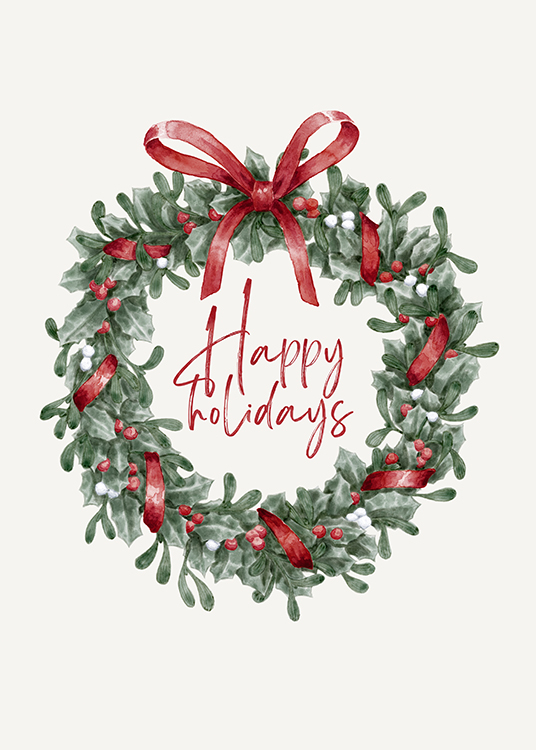

In [21]:
# Get_Stream lets you download files from a specific location in a stage and stream their content.
# The decompress argument is a setting that determines whether or not the downloaded file will be automatically decompressed using gzip.
df_stream = session.file.get_stream('@SF_INT_STG/hollidaygreetings.jpeg',decompress=False)
Image.open(df_stream)
#df_stream.close()

In [22]:
# Close Snowpark session
session.close()